# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [11]:
%%pycodestyle


class MyKmeans:

    @staticmethod
    def distance(X, Y):
        dist = - 2 * X.dot(Y.T) + (Y ** 2).sum(axis=1) +\
                (X ** 2).sum(axis=1).reshape(-1, 1)
        # В результате из-за машинного округления
        # иногда получается отрицательное число, чего не может быть
        dist[dist < 0] = 0
        return np.sqrt(dist)

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        if init == 'random':
            self.init_function = self.__init_random
        if init == 'k-means++':
            self.init_function = self.__init_kmeans_pp

    def __init_kmeans_pp(self, X):
        # Первый центройд выбираем случайным образом из объектов датасета
        # Для каждой точки рассчитываем расстояние d_min
        # Точка назначается следующим центройдом с вероятностью ~ d_min
        self.centroids[0] = X[np.random.choice(X.shape[0])]

        for i in range(1, self.k):
            distances = self.distance(X, self.centroids[:i, :]).mean(axis=1)
            w = distances / distances.sum()
            self.centroids[i] = X[np.random.choice(X.shape[0],
                                                   p=w, replace=False)]

    def __init_random(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.init_function(X)
        centroids = np.ones((self.k, X.shape[1]))

        for _ in range(self.max_iter):
            self.labels = np.argmin(self.distance(self.centroids, X), axis=0)
            centroids = [np.mean(X[self.labels == label],
                                 axis=0) for label in range(self.k)]
            if np.array_equal(centroids, self.centroids):
                break
            self.centroids = np.copy(centroids)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """

        return np.argmin(self.distance(self.centroids, X), axis=0)


class MiniBatchMyKmeans(MyKmeans):

    def __init__(self, *args, **kwargs):
        """
        Инициализация метода
        :batch_size - размер батча
        """
        self.tol = 0.01
        self.batch_size = 10
        if 'batch_size' in kwargs:
            self.batch_size = kwargs.pop('batch_size')
        if 'tol' in kwargs:
            self.tol = kwargs.pop('tol')
        super(MiniBatchMyKmeans, self).__init__(*args, **kwargs)

    def fit(self, X):
        """
        Процедура обучения MiniBatch k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(self.batch_size)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.init_function(X)
        centroids = np.ones((self.k, X.shape[1]))
        v = np.zeros(self.k)

        for i in range(self.max_iter):
            batch = X[np.random.choice(X.shape[0],
                                       self.batch_size, replace=False)]
            # Cache the center nearest to x
            self.labels = np.argmin(self.distance(self.centroids, batch),
                                    axis=0)
            for i, x in enumerate(batch):
                # Update per-center counts
                v[self.labels[i]] += 1
                # Get per-center learning rate
                learning_rate = 1 / v[self.labels[i]]
                # Take gradient step
                self.centroids[self.labels[i]] = (1 - learning_rate) * \
                    self.centroids[self.labels[i]] + learning_rate * x
            if np.all(np.abs(centroids - self.centroids) < self.tol):
                break
            centroids = np.copy(self.centroids)

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [12]:
from sklearn.datasets import make_blobs

In [13]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

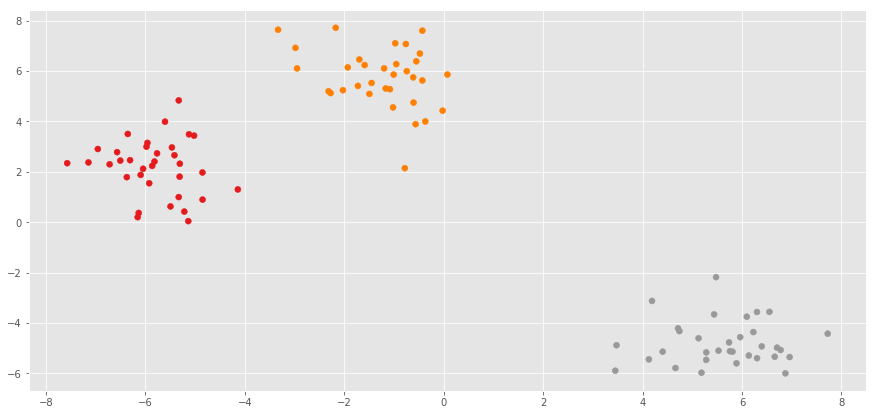

In [14]:
plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:, 1], c=y, cmap='Set1')
plt.show()

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [15]:
# Посторение на плоскости кластеров
def test_model(model):
    model.fit(X)
    y = model.predict(X)
    plt.figure(figsize=(15,7))
    N = model.k
    for i in range(N):
        plt.scatter(model.centroids[i][0], model.centroids[i][1], s=500, marker='p', cmap='Accent')
    plt.scatter(X[:,0], X[:, 1], c=y, cmap='Set2')
    plt.show()

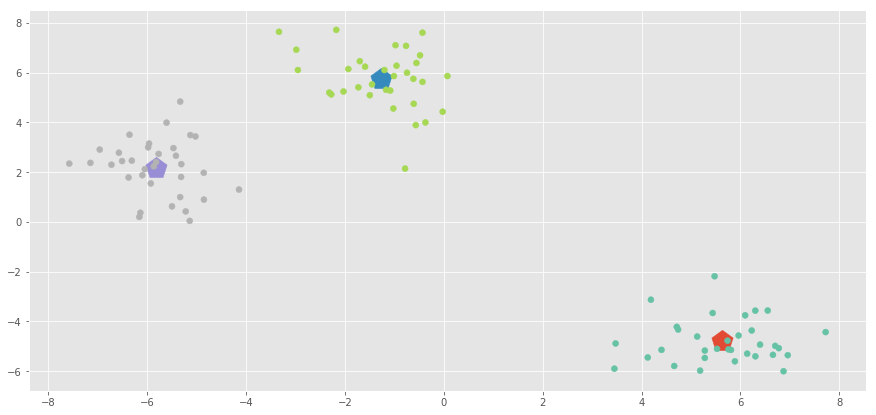

In [16]:
## Работоспособность MyKmeans
test_model(MyKmeans(k=3))

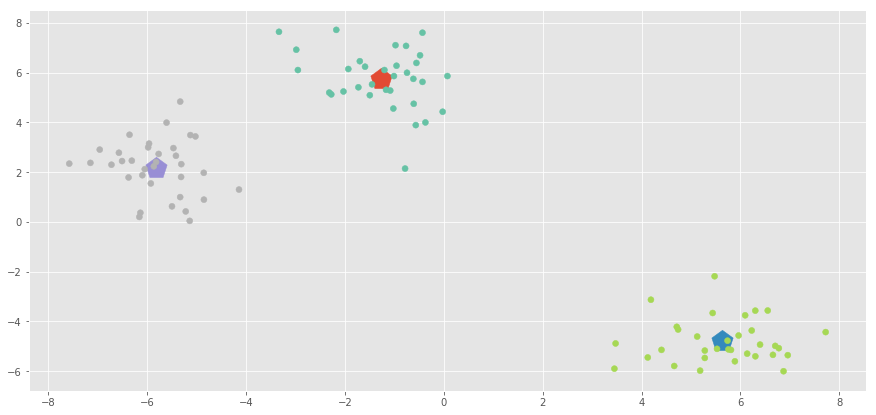

In [17]:
## Работоспособность MyKmeans++
test_model(MyKmeans(k=3, init='k-means++'))

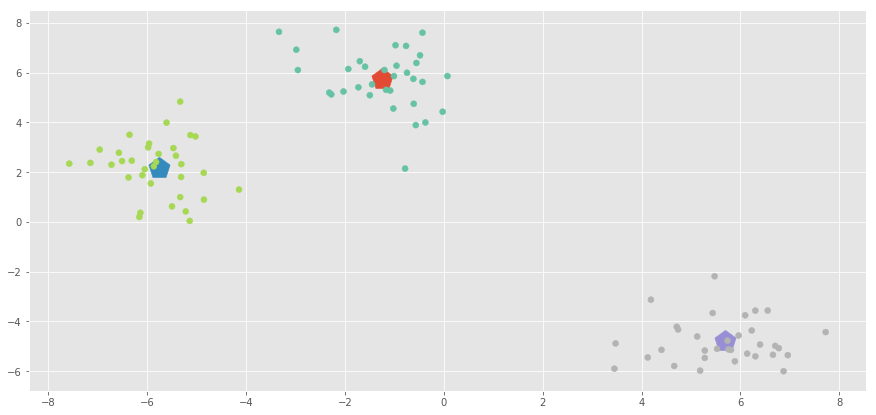

In [19]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
test_model(MiniBatchMyKmeans(k=3))

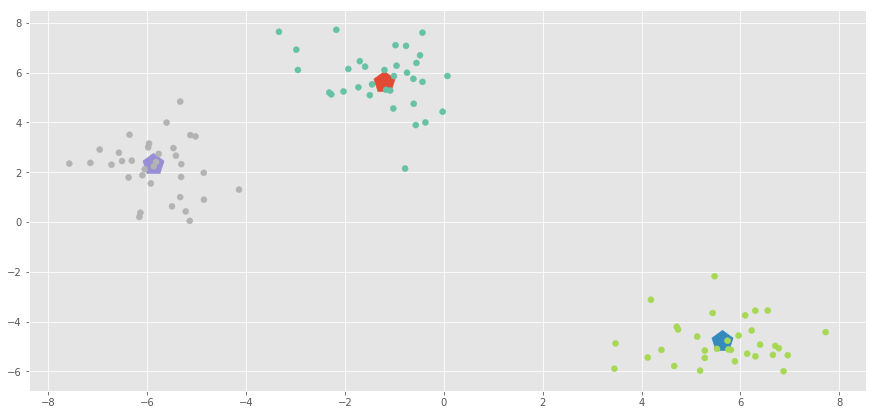

In [20]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
test_model(MiniBatchMyKmeans(k=3, init='k-means++'))

In [21]:
from sklearn.cluster import KMeans

In [22]:
## Время выполнения алгоритма Kmeans из sklearn
model = KMeans(n_clusters=3)
%time
model.fit(X)
model.predict(X)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [23]:
## Время выполнения алгоритма MyKmeans
model_my = MyKmeans(k=3)
%time
model_my.fit(X)
model_my.predict(X)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.53 µs


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
## Время выполнения алгоритма MyKmeans++
model_mypp = MyKmeans(k=3, init='k-means++' )
%time
model_mypp.fit(X)
model_mypp.predict(X)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2])

In [26]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
model_mym = MiniBatchMyKmeans(k=3)
%time
model_mym.fit(X)
model_mym.predict(X)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
model_mympp = MiniBatchMyKmeans(k=3, init='k-means++')
%time
model_mympp.fit(X)
model_mympp.predict(X)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
def test_time(model, X):
    model.fit(X)
    model.predict(X)

In [29]:
Z = 10
n_clusters = 3
n_samples = np.linspace(100, 1000000, Z, dtype=int)
models = [KMeans(n_clusters=3),
          MyKmeans(k=n_clusters),
          MyKmeans(k=n_clusters, init='k-means++'),
          MiniBatchMyKmeans(k=n_clusters),
          MiniBatchMyKmeans(k=n_clusters, init='k-means++')]
times = np.zeros((len(models), Z))
for i, n in enumerate(n_samples):
    X, y = make_blobs(n_samples=n, n_features=2, centers=3,
                      cluster_std=1, center_box=(-10.0, 10.0),
                      shuffle=False, random_state=1234)
    for j, model in enumerate(models):
        time_start = time.perf_counter()
        test_time(model, X)
        time_finish = time.perf_counter()
        times[j][i] = time_finish - time_start

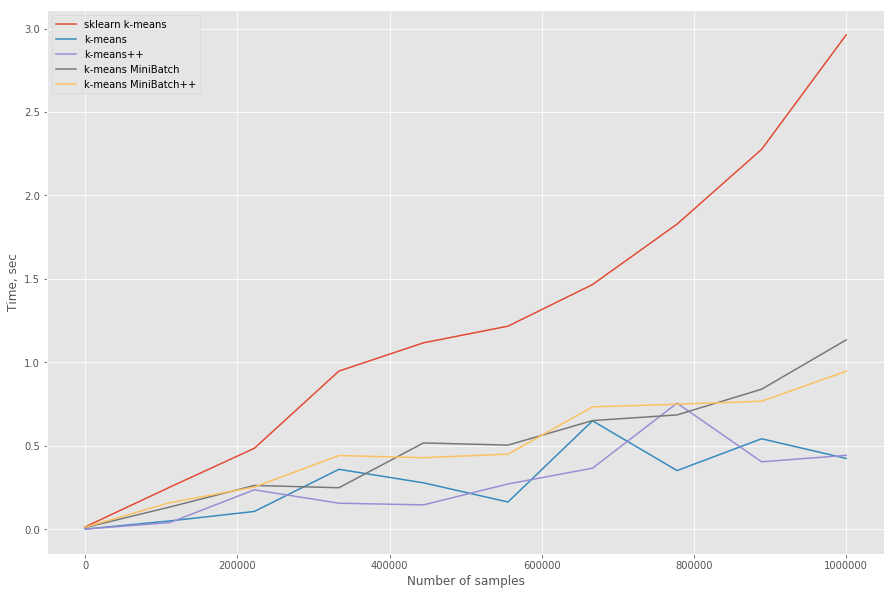

In [1314]:
algorithms = ['sklearn k-means', 'k-means', 'k-means++',
              'k-means MiniBatch', 'k-means MiniBatch++']
plt.figure(figsize=((15, 10)))
for i in range(len(models)):
    plt.plot(n_samples, times[i], label=algorithms[i])
plt.xlabel('Number of samples')
plt.ylabel('Time, sec')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [592]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [593]:
df_sns = df_sns.iloc[:,4:]
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [1018]:
dfn_sns = (df_sns - df_sns.mean()) / df_sns.std(0)
dfn_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [ ]:
n_clusters = 9

In [1322]:
def forecast(model, top_features=10):
    X = dfn_sns.values
    model.fit(X)
    y_predict = model.predict(X)
    sns_label = df_sns.copy()
    sns_label.loc[:, 'label'] = y_predict
    clusters = sns_label.groupby('label')
    for (k, group) in clusters:
        print('='*25)
        print('Cluster label = {}'. format(k))
        print('Size: {}'.format(len(group)))
        print(group.iloc[:, :-1].mean().
              sort_values(ascending=False).head(top_features))

In [1324]:
## MyKMeans

In [1032]:
%%time
forecast(MyKmeans(k=n_clusters))

Cluster label = 0
Size: 2083
basketball    1.396063
softball      1.199712
football      1.157465
volleyball    0.893903
baseball      0.863658
music         0.810850
sports        0.696111
soccer        0.602496
god           0.492559
hair          0.469995
dtype: float64
Cluster label = 1
Size: 3927
shopping    1.131907
music       0.996435
cute        0.964604
mall        0.789661
hair        0.724981
god         0.569391
church      0.529412
dance       0.422969
clothes     0.416858
hot         0.405653
dtype: float64
Cluster label = 2
Size: 1840
death       1.304891
music       0.834239
god         0.632065
hair        0.441304
die         0.436413
dance       0.349457
cute        0.305978
rock        0.290761
shopping    0.267391
band        0.259783
dtype: float64
Cluster label = 3
Size: 894
dance       5.073826
music       1.102908
hair        0.651007
god         0.562640
cute        0.561521
shopping    0.523490
church      0.421700
mall        0.387025
rock        0.370246
b

```
Кластер 0 -> спортсмены
Кластер 1 -> милые девушки,любят музыку и ходить по магазинам
Кластер 2 -> люди которые, скорее всего, слушают тяжёлую музыку, мысли смерти, мысли о Боге
Кластер 3 -> занимаются танцами
Кластер 4 -> большая группа, разносторонние личности, мысли о смерти
Кластер 5 -> люди, верущие в Бога, религиозные люди
Кластер 6 -> музыканты, состоят в группе
Кластер 7 -> тусовщики, скорее всего со странной прической
Кластер 8 -> стильные люди, любящие шоппинг

Итог: 4 - большая группа, и мысли о смерти (странно немного), в целом разделений прошло нормально
```

In [701]:
## MyKMeans++

In [1047]:
%%time
forecast(MyKmeans(k=n_clusters, init='k-means++'))

Cluster label = 0
Size: 709
hair      3.596615
sex       3.142454
music     2.610719
kissed    2.174894
rock      1.373766
die       1.203103
drugs     1.052186
dance     1.052186
blonde    1.033850
god       0.990127
dtype: float64
Cluster label = 1
Size: 840
hollister      1.517857
abercrombie    1.169048
shopping       0.938095
music          0.902381
hair           0.896429
dance          0.691667
mall           0.672619
cute           0.626190
god            0.475000
clothes        0.417857
dtype: float64
Cluster label = 2
Size: 2154
basketball    1.480501
softball      1.217734
football      1.058960
volleyball    0.930826
baseball      0.777159
music         0.776695
sports        0.662024
soccer        0.644383
god           0.468895
hair          0.434076
dtype: float64
Cluster label = 3
Size: 1311
drunk       1.421053
hair        0.707094
music       0.694127
god         0.499619
dance       0.423341
cute        0.383677
sex         0.377574
mall        0.313501
shopping    0

```
Кластер 0 -> тусовщики, слушают музыку, скорее всего со странной прической
Кластер 1 -> стильные люди, любящие шоппинг
Кластер 2 -> спортсмены
Кластер 3 -> любящие выпить, слушают музыку
Кластер 4 -> музыканты, состоят в группе
Кластер 5 -> духовные личности, любят музыку
Кластер 6 -> люди, верущие в Бога, религиозные люди
Кластер 7 -> люди которые, скорее всего, слушают тяжёлую музыку, мысли смерти, мысли о Боге
Кластер 8 -> милые девушки, любят музыку, танцевать и ходить по магазинам

Итог: достаточно хорошее разделение
```


In [703]:
## MyKMeans с MiniBatchMyKMeans

In [1063]:
%%time
forecast(MiniBatchMyKmeans(k=n_clusters))

Cluster label = 0
Size: 6
baseball      12.666667
football       2.000000
sports         1.333333
music          1.166667
rock           1.000000
church         0.833333
god            0.833333
sex            0.500000
kissed         0.500000
basketball     0.333333
dtype: float64
Cluster label = 1
Size: 400
volleyball    3.6450
softball      2.8600
basketball    1.0675
music         0.7350
shopping      0.6650
god           0.6350
hair          0.5575
football      0.5450
dance         0.5300
cute          0.4850
dtype: float64
Cluster label = 2
Size: 94
die      6.180851
god      1.638298
music    1.053191
hair     0.755319
dance    0.691489
death    0.648936
rock     0.393617
cute     0.372340
band     0.319149
jesus    0.319149
dtype: float64
Cluster label = 3
Size: 753
mall          2.807437
cute          1.428951
hair          1.402390
shopping      1.229748
dance         1.107570
music         1.057105
hot           0.815405
clothes       0.762284
god           0.632138
basketbal

```
Кластер 0 -> спортсмены
Кластер 1 -> спортсмены
Кластер 2 -> люди которые, скорее всего, слушают тяжёлую музыку, мысли смерти, мысли о Боге
Кластер 3 -> милые девушки, следящие за своими волосами, любящие ходить по магазинам
Кластер 4 -> тусовщики с вредными привычками
Кластер 5 -> музыканты, любящие рок
Кластер 6 -> духовные личности,верят в Бога, любят музыку
Кластер 7 -> музыканты, состоят в группе
Кластер 8 -> разносторонние личности

Итог: 0 и 1 можно объединить
      5 и 7 можно объединить
      кластер №8 - не совсем четкий
```

In [851]:
## MyKMeans++ с MiniBatchMyKMeans

In [1103]:
%%time
forecast(MiniBatchMyKmeans(k=n_clusters, init='k-means++'))

Cluster label = 0
Size: 324
volleyball    4.558642
softball      1.737654
basketball    0.901235
music         0.777778
shopping      0.725309
hair          0.645062
god           0.608025
cute          0.577160
dance         0.555556
football      0.540123
dtype: float64
Cluster label = 1
Size: 3157
shopping      1.176750
mall          1.052265
music         1.030409
hair          0.891036
cute          0.841305
dance         0.820082
church        0.699715
basketball    0.687045
god           0.614191
clothes       0.494774
dtype: float64
Cluster label = 2
Size: 1305
hair      2.077395
sex       1.724904
music     1.451341
die       1.055172
god       1.009195
death     0.990805
kissed    0.979310
dance     0.879693
drunk     0.874330
drugs     0.715709
dtype: float64
Cluster label = 3
Size: 575
dress         2.516522
dance         1.187826
hair          0.960000
music         0.869565
shopping      0.773913
cute          0.706087
god           0.560000
mall          0.532174
church 

```
Кластер 0 -> спортсмены
Кластер 1 -> милые девушки, следящие за своими волосами, любящие ходить по магазинам
Кластер 2 -> тусовщики с вредными привычками
Кластер 3 -> девушки, любят музыку и танцевать
Кластер 4 -> религиозные люди
Кластер 5 -> музыканты, любящие рок
Кластер 6 -> девушки-блондинки
Кластер 7 -> духовные личности,верят в Бога, любят музыку
Кластер 8 -> музыканты, состоят в группе

Итог: 5 и 8 можно объединить. Не самая лучшая кластеризация
```

In [707]:
## Вывод

* Каждый алгоритм хорош по своему. На игрушечных данных выигрыш в скорости от MiniBatch реализации был неощутимым, так как данных очень мало, а k-means иногда мог делить один кластер на два в силу случайной инициализации. Стабильно хорошо себя ведет k-means++
* При работе с данными об учащихся, k-means++ в среднем вех больше тратит времени, что связано с его инициализацией. MiniBatch же работает быстрее, но часто делает много похожих кластеров, я думаю, что MiniBatch нужно применять для более больших наборов данных и большем количестве кластеров, там он себя проявит. 
* Но  MiniBatch имеет дополнительные гиперпараметры, что является его минусом. Группы учащихся, получившиеся с помощью всех моделей очень похожи, но k-means++, делает объединение чуть лучше остальных, но назвать его лучшим сложно, работает он чуть медленнее. Выявить одного явного лидера среди алгоритмов сложно. Группы людей, получились следующие:

```
Кластер 1 -> девушки, любящие ходить по магазинам  
Кластер 2 -> музыканты, любящие рок, состоящие в группе
Кластер 3 -> спортсмены
Кластер 4 -> религиозные люди, мысли смерти, мысли о Боге
Кластер 5 -> стильные люди, помешанные на моде
Кластер 6 -> тусовщики с вредными привычками, со странной прической
Кластер 7 -> милые девушки, занимаются танцами
Кластер 8 -> девушки-чирлидеры
Кластер 9 -> духовные личности, любят музыку
```